In [3]:
import os
import sys
sys.path.append('/zfsauton3/home/bparia/hf_moe/')

import numpy as np
from sklearn.preprocessing import OrdinalEncoder, minmax_scale, StandardScaler
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pickle

In [4]:
cd /zfsauton3/home/bparia/hf_moe/notebooks

/zfsauton3/home/bparia/hf_moe/notebooks


In [6]:
with open('../data/favorita/data.pkl', 'rb') as fin:
    tree, ts_data, \
        (global_cont_feats, global_cat_feats, global_cat_dims) \
            = pickle.load(fin)
leaf_mat = tree.leaf_matrix.T
num_leaf = np.sum(leaf_mat, axis=0, keepdims=True)
ts_data_norm = ts_data / num_leaf

0
(1688, 4471)


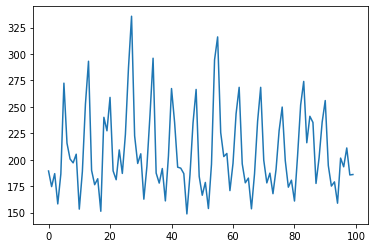

In [64]:
idx = np.random.choice(tree.levels[0])
print(idx)
plt.plot(ts_data_norm[-100:, idx])
print(ts_data_norm.shape)

# Plotting predictions

In [80]:
with open('evals.pkl', 'rb') as fin:
    y_pred, y_true = pickle.load(fin)

1300


[]

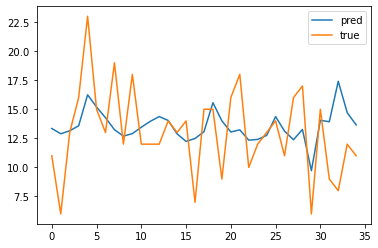

In [88]:
idx = np.random.choice(tree.levels[3])
print(idx)
plt.plot(y_pred[:, idx], label='pred')
plt.plot(y_true[:, idx], label='true')
plt.legend()
plt.plot()

# Training data preprocessing code

In [3]:
df = pd.read_csv('../data/favorita/train.csv')
df['date'] = pd.to_datetime(df['date'])
df

/zfsauton3/home/bparia/miniconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
...,...,...,...,...,...,...
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True


In [86]:
start_date = dt.datetime.strptime('2013-01-21', '%Y-%m-%d')
end_date = dt.datetime.strptime('2017-08-15', '%Y-%m-%d')
delta = end_date - start_date
num_days = delta.days
print(num_days)
for row in df[['date', 'item_nbr', 'unit_sales']].itertuples():
    print(row)
    break
df['date'].min(), df['date'].max()


1667
Pandas(Index=0, date=Timestamp('2013-01-01 00:00:00'), item_nbr=103665, unit_sales=7.0)


(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [92]:
items = pd.read_csv('../data/favorita/items.csv')
items.rename(columns={'class': 'clas'}, inplace=True)
for tup in items.itertuples():
    print(tup)
    item_nbr = tup.item_nbr
    family = tup.family
    clas = tup.clas
    node_str = f'{family}_{clas}_{item_nbr}'
    print(node_str)
    break
# items['family'].unique()
# items.iloc[1230:]

Pandas(Index=0, item_nbr=96995, family='GROCERY I', clas=1093, perishable=0)
GROCERY I_1093_96995


In [24]:
items['item_nbr'].min(), items['item_nbr'].max()

(96995, 2134244)

In [85]:
events = pd.read_csv('../data/favorita/holidays_events.csv')
events['date'] = pd.to_datetime(events['date'])
global_cat_feats = [[''] * 4 for i in range(num_days)]

cat_feat_list = ['type', 'locale', 'locale_name', 'transferred']
events = events[['date'] + cat_feat_list].fillna('')

for row in events.itertuples():
    day_num = (row.date - start_date).days
    if day_num in range(0, num_days):
        global_cat_feats[day_num][0] = row.type
        global_cat_feats[day_num][1] = row.locale
        global_cat_feats[day_num][2] = row.locale_name
        global_cat_feats[day_num][3] = 'yes' if row.transferred else ''

enc = OrdinalEncoder(dtype=np.int32)
global_cat_feats = enc.fit_transform(global_cat_feats)
global_cat_feats = [global_cat_feats[:, i] for i in range(len(cat_feat_list))]
global_cat_dims = [len(cat) for cat in enc.categories_]

[7, 4, 23, 2]

In [62]:
oil = pd.read_csv('../data/favorita/oil.csv')
oil['date'] = pd.to_datetime(oil['date'])
x_dates = []
y_prices = []

idx = 0
for row in oil.itertuples():
    day_num = (row.date - start_date).days
    price = row.dcoilwtico
    if not np.isnan(price):
        x_dates.append(day_num)
        y_prices.append(price)
prices = np.interp(range(num_days), x_dates, y_prices)
wday = []
month = []
for i in range(num_days):
    new_date = start_date + dt.timedelta(days=i)
    wday.append(new_date.weekday())
    month.append(new_date.month)
wday = np.array(wday, dtype=np.float32)
month = np.array(month, dtype=np.float32)

np.vstack([prices, wday, month]).shape

(3, 1667)

In [32]:
# Not using this
transactions = pd.read_csv('../data/favorita/transactions.csv')
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
